In [ ]:
# install specific numpy version to avoid compatibility issues with tensorflow
pip install "numpy==1.26.4" 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# verify numpy version
import numpy
print(numpy.__version__)

1.26.4



We import TensorFlow / Keras to build and train the model.
pathlib helps with folder paths.
The set_visible_devices block is only to disable GPU and make sure it runs on CPU.


In [ ]:
# this part is for the libraries we use.
# tensorflow for the model. others for tools we need.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pathlib

# try to disable GPU to avoid potential issues.

try:
    tf.config.set_visible_devices([], 'GPU')
except:
    pass

2025-12-10 08:21:23.946075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Set the dataset path and basic settings


In [ ]:
# this is the path to folder.

data_dir = pathlib.Path("/Users/hatemelgenedy/Desktop/AI and Data Science Microsoft course/AIDER")

# here we set some basic settings.
# image size. batch size. number of classes.

IMG_SIZE = (224, 224) # resize all images to 224x224
BATCH_SIZE = 32 # number of images to process in a batch
NUM_CLASSES = 5   # collapsed_building, fire, flooded_areas, normal, traffic_incident

In [8]:
# here we load the images from folders.
# keras uses folder names as the labels.
# we also split the data into training and validation sets.
# 20% for validation. 80% for training.
# we set a seed for reproducibility.
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# this prints the class names.
# so we can check the order.

class_names = train_ds.class_names
print("Classes:", class_names)

Found 6433 files belonging to 5 classes.
Using 5147 files for training.
Found 6433 files belonging to 5 classes.
Using 1286 files for validation.
Classes: ['collapsed_building', 'fire', 'flooded_areas', 'normal', 'traffic_incident']


.cache() keeps the data in memory after first read.
.shuffle(500) randomizes the order of training examples.
.prefetch() lets the CPU prepare the next batch while the model is training on the current one.

In [9]:
# this part makes loading faster.
# cache in memory. prefetch next batch.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(500).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

# Data augmentation

In [10]:
# here we make small random changes to images.
# this helps the model generalize better.

data_augmentation = keras.Sequential([ 
    layers.RandomFlip("horizontal"), # randomly flip images horizontally
    layers.RandomRotation(0.1), # randomly rotate images by 10%
    layers.RandomZoom(0.1), # randomly zoom in by 10%
])

In [11]:
# this is our cnn model.
# it takes an image and outputs 5 class scores.

inputs = keras.Input(shape=IMG_SIZE + (3,))

# first we do augmentation and rescaling.
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# first conv block. simple features.
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)

# second conv block. deeper features.
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)

# third conv block. more abstract features.
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)

# flatten feature maps and use dense layers.
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# final layer for 5 classes.
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                             

In [12]:
print("All physical devices:", tf.config.list_physical_devices())
print("GPUs:", tf.config.list_physical_devices('GPU'))

All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs: []


# Compile the model

Adam optimizer updates weights efficiently with learning rate 0.001.
sparse_categorical_crossentropy is correct because labels are integers.
We track accuracy during training and validation.

In [13]:
# here we choose how the model learns.
# optimizer, loss, and metric.

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [14]:
# now we train the model.
# cpu will be used here because we disabled gpu.

EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
161/161 [==============================] - 231s 1s/step - loss: 0.9793 - accuracy: 0.6808 - val_loss: 0.7383 - val_accuracy: 0.7379
Epoch 2/20
161/161 [==============================] - 225s 1s/step - loss: 0.7707 - accuracy: 0.7220 - val_loss: 0.6766 - val_accuracy: 0.7442
Epoch 3/20
161/161 [==============================] - 217s 1s/step - loss: 0.6895 - accuracy: 0.7472 - val_loss: 0.7109 - val_accuracy: 0.7364
Epoch 4/20
161/161 [==============================] - 197s 1s/step - loss: 0.6422 - accuracy: 0.7632 - val_loss: 0.6068 - val_accuracy: 0.7869
Epoch 5/20
161/161 [==============================] - 196s 1s/step - loss: 0.6235 - accuracy: 0.7721 - val_loss: 0.5765 - val_accuracy: 0.7776
Epoch 6/20
161/161 [==============================] - 197s 1s/step - loss: 0.5940 - accuracy: 0.7781 - val_loss: 0.5768 - val_accuracy: 0.7947
Epoch 7/20
161/161 [==============================] - 199s 1s/step - loss: 0.5597 - accuracy: 0.7876 - val_loss: 0.5739 - val_accuracy: 0.7978

In [15]:
# get final loss and accuracy for the CNN.
# this tells us how good the cnn model is.

val_loss, val_acc = model.evaluate(val_ds)
print("CNN Validation Loss:", val_loss)
print("CNN Validation Accuracy:", val_acc)

41/41 [==============================] - 11s 262ms/step - loss: 0.5171 - accuracy: 0.8173
CNN Validation Loss: 0.5171206593513489
CNN Validation Accuracy: 0.8172628283500671


In [16]:
# import sklearn tools for confusion matrix and report.
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np

In [17]:
# collect predictions and true labels from validation set.
# we use these to build the confusion matrix.

all_preds = []
all_labels = []

for image , labels in val_ds:
    preds = model.predict(image)
    pred_classes = np.argmax(preds , axis = 1)

    all_preds.extend(pred_classes)
    all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


1/1 [==============================] - 0s 138ms/step


In [ ]:
# this prints the confusion matrix.
# rows = true labels, columns = predicted labels.

cm = confusion_matrix(all_labels , all_preds) 
print("Confusion Matrix:")
print(cm)

# this prints a detailed classification report.
report = classification_report(all_labels , all_preds , target_names = class_names)

Confusion Matrix:
[[ 82   1   2  11   4]
 [  5  63   2  18   1]
 [  6   1  79   4  11]
 [ 59  15  37 766  11]
 [ 26   0   7  14  61]]


In [19]:
# save the cnn model so we don't lose training.
# we can load it later without retraining.

model.save("cnn_model_aider_cpu.h5")

In [23]:
# function to test the cnn on one image.
# prints the predicted class name.

from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

def predict_one_image_cnn(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    preds = model.predict(img_array)
    pred_class = np.argmax(preds, axis=1)[0]

    print("Predicted class:", class_names[pred_class])

In [ ]:
# test the function with one image from the dataset.
from pathlib import Path

# this gets one sample image from  AIDER dataset automatically.
sample_image_path = next(Path(data_dir).rglob("*.jpg"))

print("Testing image:", sample_image_path)

predict_one_image_cnn(str(sample_image_path))

Testing image: /Users/hatemelgenedy/Desktop/AI and Data Science Microsoft course/AIDER/collapsed_building/collapsed_building_image0233.jpg
1/1 [==============================] - 0s 59ms/step
Predicted class: normal


In [26]:
# this part gets all images, labels, and predictions.
# we use the validation set for evaluation and plots.
# We loop through every batch in the validation dataset.
# For each batch, we get predictions and store images, true labels, and predicted classes.
#At the end, we merge all batches into single arrays.
import matplotlib.pyplot as plt

all_images = []
all_labels = []
all_preds = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)

    all_images.append(images.numpy())
    all_labels.append(labels.numpy())
    all_preds.append(preds_classes)

# turn lists of batches into single big arrays.
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

1/1 [==============================] - 0s 82ms/step


# Overall accuracy and per-class accuracy bar chart

In [27]:
# compute overall accuracy from predictions.
# simple percentage of correct predictions.

overall_accuracy = np.mean(all_preds == all_labels)
print("Overall validation accuracy (from predictions):", overall_accuracy)

# compute accuracy for each class separately.
class_accuracies = []
for i, class_name in enumerate(class_names):
    mask = (all_labels == i)
    if np.sum(mask) > 0:
        acc_i = np.mean(all_preds[mask] == all_labels[mask])
    else:
        acc_i = 0.0
    class_accuracies.append(acc_i)
    print(f"Class '{class_name}' accuracy:", acc_i)

Overall validation accuracy (from predictions): 0.8172628304821151
Class 'collapsed_building' accuracy: 0.82
Class 'fire' accuracy: 0.7078651685393258
Class 'flooded_areas' accuracy: 0.7821782178217822
Class 'normal' accuracy: 0.8626126126126126
Class 'traffic_incident' accuracy: 0.5648148148148148


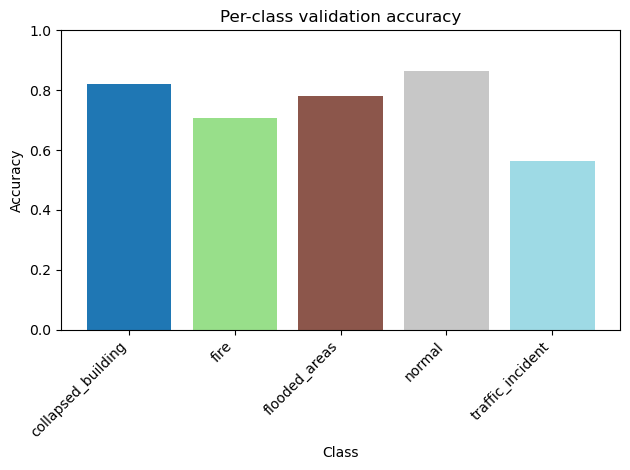

In [32]:
# plot per-class accuracy as a bar chart.
# each bar is one class from the dataset.

# generate N different colors automatically
colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))

plt.figure()
plt.bar(range(len(class_names)), class_accuracies , color = colors)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.ylim(0, 1)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-class validation accuracy")
plt.tight_layout()
plt.show()

We first compute overall accuracy using all predictions.
Then we loop by class (collapsed_building, fire, etc.) and calculate accuracy for each one.
We plot a bar chart where each bar shows how accurate the model is on that specific class.

Confusion matrix:
[[ 82   1   2  11   4]
 [  5  63   2  18   1]
 [  6   1  79   4  11]
 [ 59  15  37 766  11]
 [ 26   0   7  14  61]]


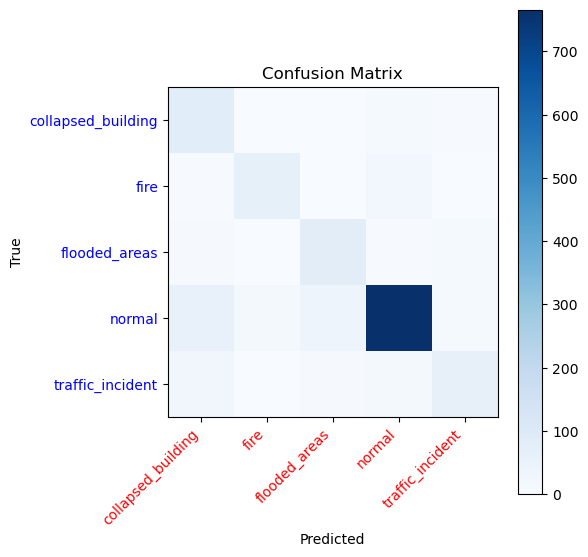

In [ ]:
# make the confusion matrix from true and predicted labels.
# rows = true class. columns = predicted class.
# each cell shows number of samples.
# We use sklearn's confusion_matrix function to compute the matrix.
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:")
print(cm)

# show the confusion matrix as an image.
plt.figure(figsize=(6, 6))
plt.imshow(cm , cmap = 'Blues')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right" , color = 'red')
plt.yticks(range(len(class_names)), class_names , color = 'blue')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.colorbar()
plt.tight_layout()
plt.show()

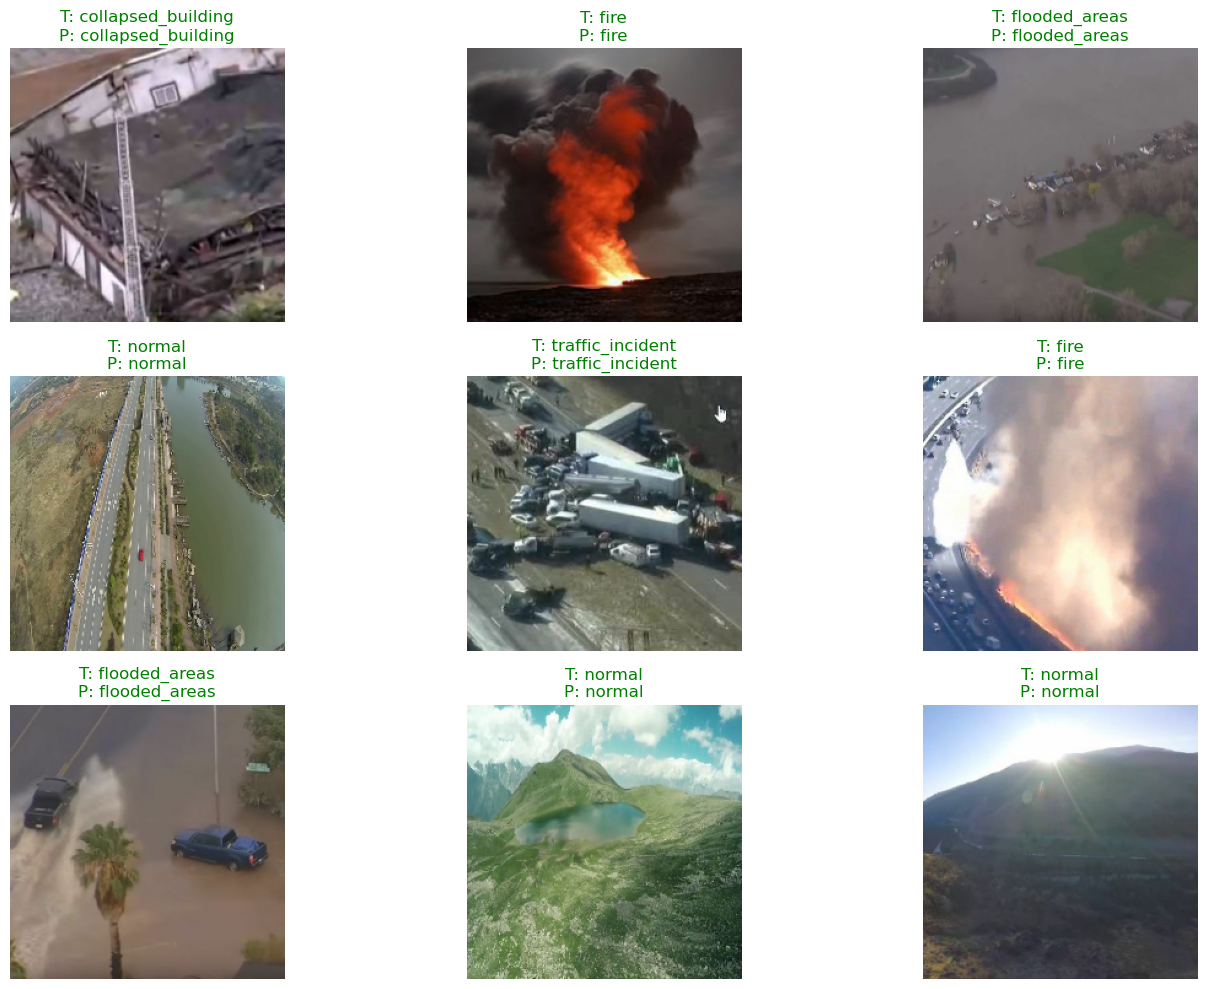

In [52]:
# show 9 images: one from each class + extra random images.
# we display true and predicted labels. green = correct, red = wrong.



unique_classes = list(range(len(class_names)))  # 0..4
images_to_show = []

# ---- Step 1: get one random image from each class ----
for class_id in unique_classes:
    indices = np.where(all_labels == class_id)[0]
    random_index = np.random.choice(indices)
    images_to_show.append(random_index)

# ---- Step 2: add 4 more random images (from all validation images) ----
remaining_needed = 9 - len(images_to_show)
all_indices = np.arange(len(all_labels))

extra_indices = np.random.choice(all_indices, remaining_needed, replace=False)
images_to_show.extend(extra_indices)

# ---- Step 3: plot the 9 images ----
plt.figure(figsize=(15, 10))

for i, idx in enumerate(images_to_show):
    img = all_images[idx].astype("uint8")
    true_name = class_names[all_labels[idx]]
    pred_name = class_names[all_preds[idx]]

    color = "green" if true_name == pred_name else "red"

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"T: {true_name}\nP: {pred_name}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [55]:
# find the indices of wrong predictions.
wrong_indices = np.where(all_preds != all_labels)[0]
print("Number of wrong predictions:", len(wrong_indices))

Number of wrong predictions: 235


We first find where predictions don’t match true labels.
Then we show a grid of some wrong examples, which is very useful in a report to explain model weaknesses.

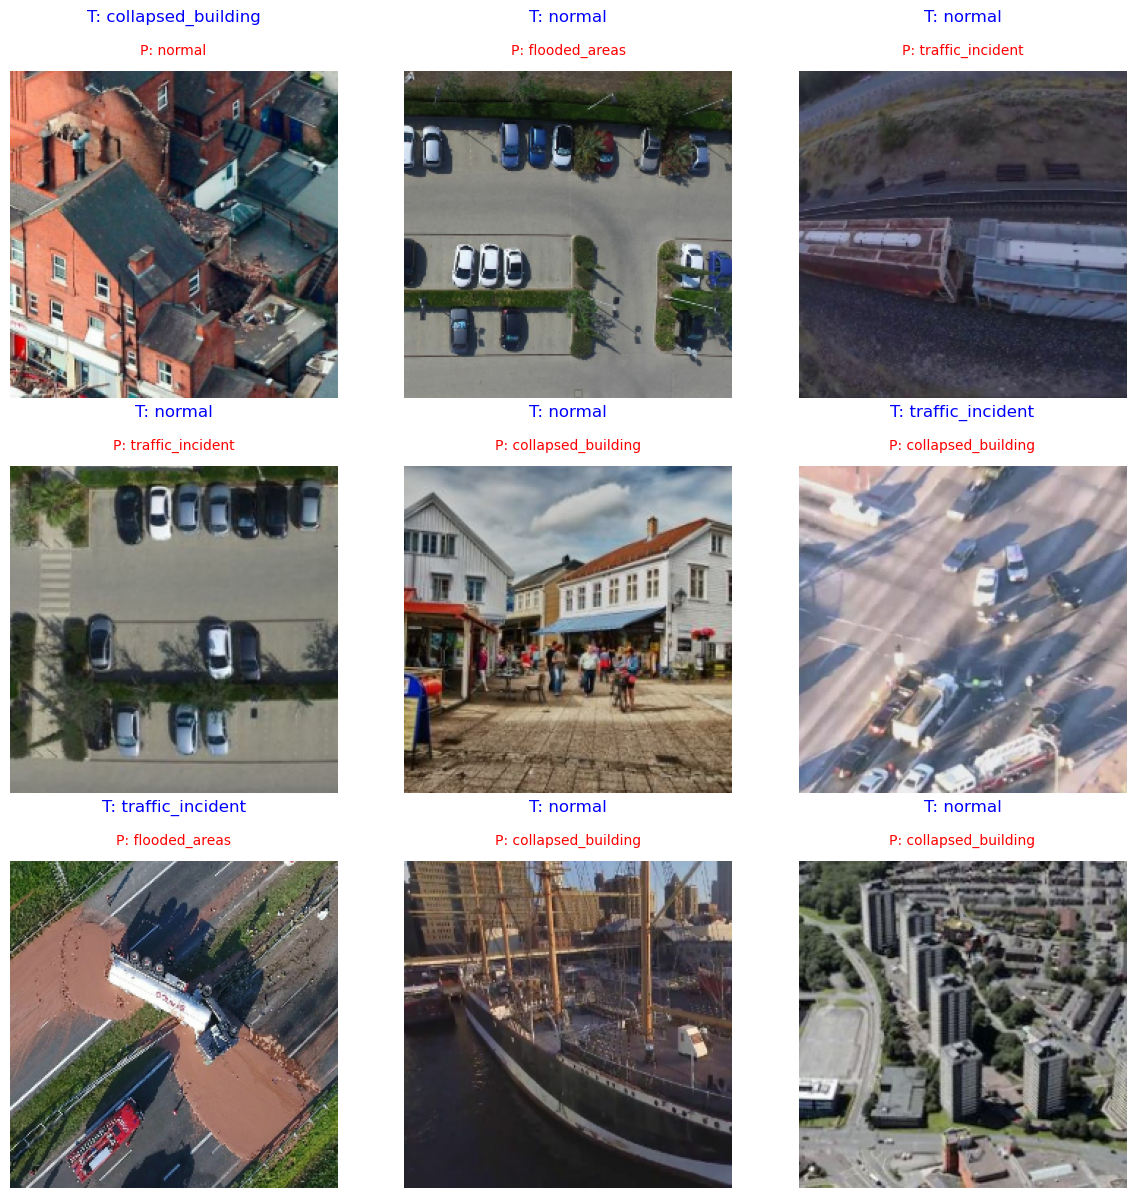

In [72]:
# show wrong predictions with colored labels.
# true label is blue. predicted label is green or red.
# red means wrong prediction. green means correct prediction.

num_show_wrong = min(9, len(wrong_indices))   # show up to 9 wrong images.
plt.figure(figsize=(12, 12))                  # set the figure size for 3x3 grid.

for i in range(num_show_wrong):
    idx = wrong_indices[i]        # get index of a wrong prediction.
    img = all_images[idx].astype("uint8")  # get the image and cast to uint8.

    true_name = class_names[all_labels[idx]]   # get true class name for this image.
    pred_name = class_names[all_preds[idx]]    # get predicted class name.

    pred_color = "green" if true_name == pred_name else "red"
    # choose color for predicted label.
    # green if correct. red if wrong.

    plt.subplot(3, 3, i + 1)    # select position in 3x3 plot.
    plt.imshow(img)             # show the image.
    plt.axis("off")             # hide axes for clean look.

    # draw true label text above image.
    # use blue color to show it is the real class.
    plt.text(0.5, 1.15, f"T: {true_name}", color="blue",
             ha="center", fontsize=12, transform=plt.gca().transAxes)

    # draw predicted label text below the true label.
    # color is green if correct, red if wrong.
    plt.text(0.5, 1.05, f"P: {pred_name}", color=pred_color,
             ha="center", fontsize=10, transform=plt.gca().transAxes)

plt.tight_layout()   # adjust layout so texts and images do not overlap.
plt.show()          

# Build the MobileNetV2 base

In [73]:
# create the mobilenetv2 base model.
# remove the original imagenet classifier.
# use pretrained imagenet weights.

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

# freeze the base model at first.
# we only train our own top layers.

base_model.trainable = False

# Add our classifier on top of MobileNetV2

In [74]:
# build the full model using mobilenetv2.
# add pooling, dropout and final dense layer.

inputs = keras.Input(shape=IMG_SIZE + (3,))

# use our data augmentation.
# then use mobilenetv2 preprocessing.

x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# pass through the mobilenetv2 base.
x = base_model(x, training=False)

# global average pooling to reduce features.
x = layers.GlobalAveragePooling2D()(x)

# dropout to reduce overfitting.
x = layers.Dropout(0.3)(x)

# final dense layer for 5 classes.
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

mobilenet_model = keras.Model(inputs, outputs)
mobilenet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

# Compile the MobileNetV2 model

In [75]:
# set optimizer, loss, and metric.
# similar settings to the cnn.

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train only the new top layers (head)

In [78]:
# train only the new top layers.
# mobilenetv2 base stays frozen.

EPOCHS_HEAD = 10 

history_mobilenet_head = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD
)

Epoch 1/10


161/161 [==============================] - 320s 2s/step - loss: 0.3856 - accuracy: 0.8642 - val_loss: 0.2737 - val_accuracy: 0.9044
Epoch 2/10
161/161 [==============================] - 231s 1s/step - loss: 0.3090 - accuracy: 0.8912 - val_loss: 0.2548 - val_accuracy: 0.9059
Epoch 3/10
161/161 [==============================] - 267s 2s/step - loss: 0.2662 - accuracy: 0.9046 - val_loss: 0.2421 - val_accuracy: 0.9106
Epoch 4/10
161/161 [==============================] - 314s 2s/step - loss: 0.2588 - accuracy: 0.9089 - val_loss: 0.2212 - val_accuracy: 0.9215
Epoch 5/10
161/161 [==============================] - 195s 1s/step - loss: 0.2366 - accuracy: 0.9176 - val_loss: 0.2394 - val_accuracy: 0.9098
Epoch 6/10
161/161 [==============================] - 185s 1s/step - loss: 0.2229 - accuracy: 0.9215 - val_loss: 0.2223 - val_accuracy: 0.9215
Epoch 7/10
161/161 [==============================] - 182s 1s/step - loss: 0.2102 - accuracy: 0.9289 - val_loss: 0.2129 - val_accuracy: 0.9269
Epoch 8/10

# Evaluate after head training

In [79]:
# check performance after head training.
# this lets us compare with the cnn.

val_loss_head, val_acc_head = mobilenet_model.evaluate(val_ds)
print("MobileNetV2 (head) val loss:", val_loss_head)
print("MobileNetV2 (head) val acc :", val_acc_head)

41/41 [==============================] - 30s 723ms/step - loss: 0.2190 - accuracy: 0.9199
MobileNetV2 (head) val loss: 0.2189582884311676
MobileNetV2 (head) val acc : 0.9199066758155823


# Fine-tune deeper layers

In [80]:
# now unfreeze the base model.
# we keep some early layers frozen.

base_model.trainable = True

# keep first 100 layers frozen (optional).
# so we fine-tune only deeper layers.

for layer in base_model.layers[:100]:
    layer.trainable = False

# recompile with smaller learning rate.
# small steps for fine-tuning.

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [81]:
# fine-tune mobilenetv2 with small learning rate.
# this usually gives best accuracy.

EPOCHS_FINE = 10

history_mobilenet_fine = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINE
)

Epoch 1/10
161/161 [==============================] - 252s 2s/step - loss: 0.3253 - accuracy: 0.8941 - val_loss: 0.3013 - val_accuracy: 0.9036
Epoch 2/10
161/161 [==============================] - 245s 2s/step - loss: 0.2001 - accuracy: 0.9291 - val_loss: 0.2040 - val_accuracy: 0.9308
Epoch 3/10
161/161 [==============================] - 245s 2s/step - loss: 0.1389 - accuracy: 0.9543 - val_loss: 0.1631 - val_accuracy: 0.9495
Epoch 4/10
161/161 [==============================] - 250s 2s/step - loss: 0.1212 - accuracy: 0.9592 - val_loss: 0.1589 - val_accuracy: 0.9565
Epoch 5/10
161/161 [==============================] - 251s 2s/step - loss: 0.0921 - accuracy: 0.9672 - val_loss: 0.1764 - val_accuracy: 0.9557
Epoch 6/10
161/161 [==============================] - 255s 2s/step - loss: 0.0900 - accuracy: 0.9701 - val_loss: 0.1435 - val_accuracy: 0.9572
Epoch 7/10
161/161 [==============================] - 258s 2s/step - loss: 0.0577 - accuracy: 0.9813 - val_loss: 0.1815 - val_accuracy: 0.9401

# Final eval + save the MobileNetV2 model

In [82]:
# final evaluation after fine-tuning.
# this is our best mobilenetv2 score.

val_loss_final, val_acc_final = mobilenet_model.evaluate(val_ds)
print("MobileNetV2 final val loss:", val_loss_final)
print("MobileNetV2 final val acc :", val_acc_final)

# save the mobilenetv2 model.
# so we can use it later.

mobilenet_model.save("aider_mobilenetv2_cpu.h5")

41/41 [==============================] - 33s 815ms/step - loss: 0.1192 - accuracy: 0.9681
MobileNetV2 final val loss: 0.11923548579216003
MobileNetV2 final val acc : 0.9681181907653809


# Metrics and visualisations (for MobileNetV2)

In [83]:
# collect images, true labels, and predictions.
# we use validation set for this.

all_images = []
all_labels = []
all_preds = []
# loop through every batch in validation dataset.
for images, labels in val_ds:
    preds = mobilenet_model.predict(images)
    preds_classes = np.argmax(preds, axis=1)

    all_images.append(images.numpy())
    all_labels.append(labels.numpy())
    all_preds.append(preds_classes)
# turn lists of batches into single big arrays.
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

1/1 [==============================] - 2s 2s/step


In [84]:
# overall accuracy from predictions.
# simple mean of correct matches.

overall_accuracy = np.mean(all_preds == all_labels)
print("Overall validation accuracy:", overall_accuracy)

# per-class accuracy list.
class_accuracies = []
for i, name in enumerate(class_names):
    mask = (all_labels == i)
    if np.sum(mask) > 0:
        acc_i = np.mean(all_preds[mask] == all_labels[mask])
    else:
        acc_i = 0.0
    class_accuracies.append(acc_i)
    print(f"Class '{name}' accuracy:", acc_i)

Overall validation accuracy: 0.9681181959564541
Class 'collapsed_building' accuracy: 0.91
Class 'fire' accuracy: 0.9662921348314607
Class 'flooded_areas' accuracy: 0.9702970297029703
Class 'normal' accuracy: 0.9763513513513513
Class 'traffic_incident' accuracy: 0.9537037037037037


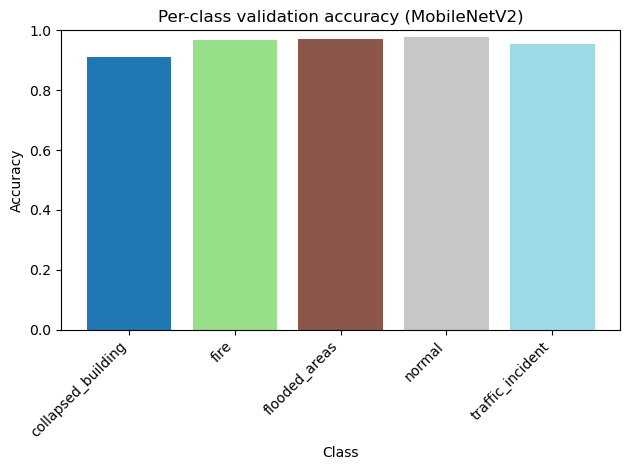

In [89]:
# bar chart for per-class accuracy.
# each bar is one class.

colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))
plt.figure()
plt.bar(range(len(class_names)), class_accuracies, color=colors)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.ylim(0, 1)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-class validation accuracy (MobileNetV2)")
plt.tight_layout()
plt.show()

Confusion matrix:
[[ 91   1   0   5   3]
 [  1  86   0   1   1]
 [  0   0  98   1   2]
 [  5   0   8 867   8]
 [  0   0   2   3 103]]


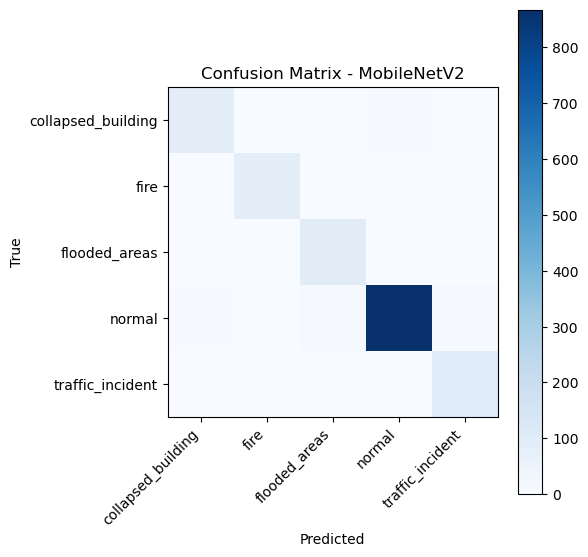

In [90]:
# confusion matrix for mobilenetv2.
# rows true labels, columns predicted labels.

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:")
print(cm)

plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Blues")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MobileNetV2")
plt.colorbar()
plt.tight_layout()
plt.show()

# 9 random images (one from each class + extra)

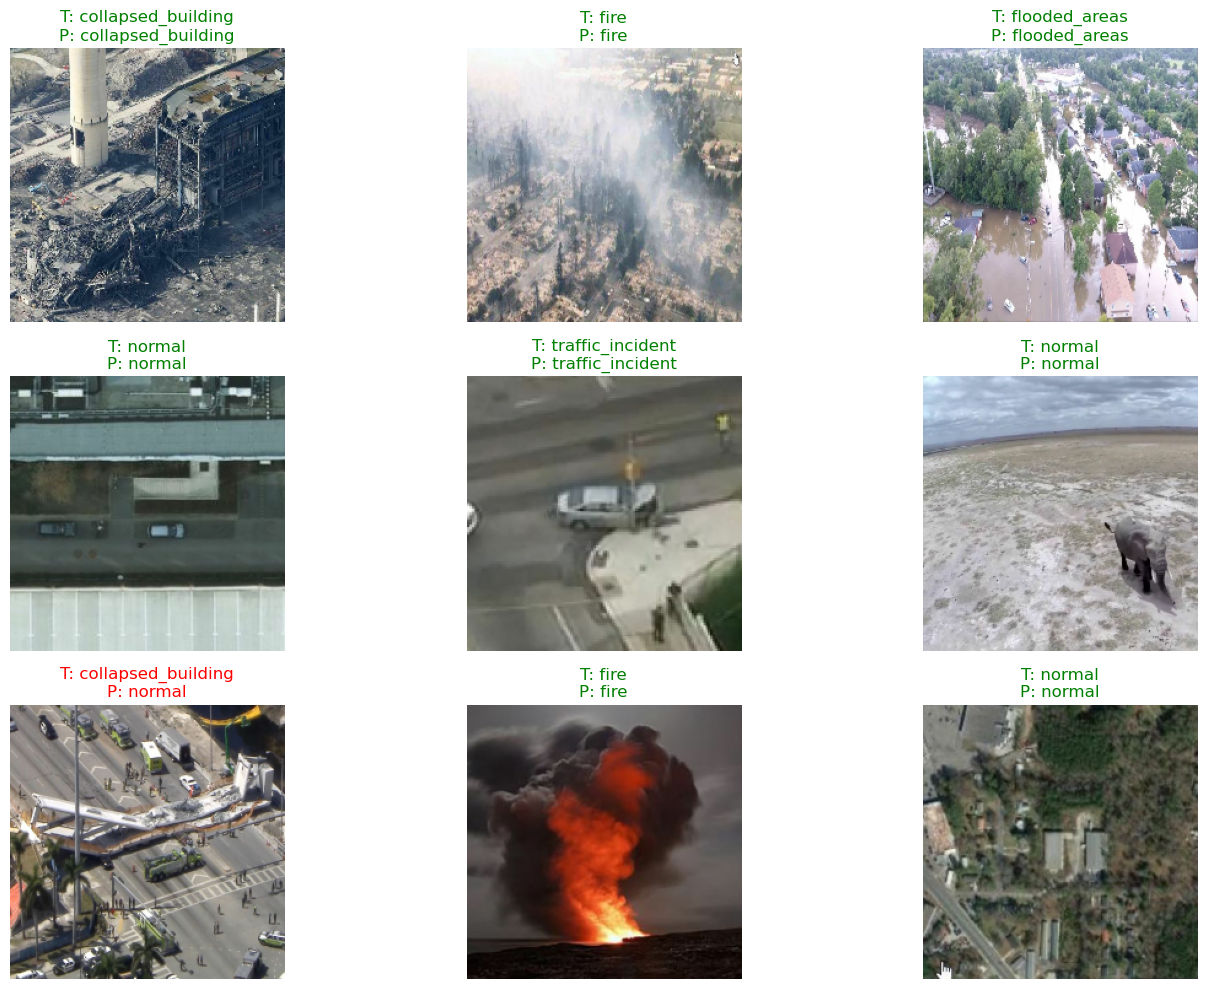

In [ ]:
# show 9 images. at least one from each class.
# display true and predicted labels.

unique_classes = list(range(len(class_names)))
images_to_show = []

# one random from each class.
for class_id in unique_classes:
    idxs = np.where(all_labels == class_id)[0]
    rand_idx = np.random.choice(idxs)
    images_to_show.append(rand_idx)

# add extra random images to make 9.
remaining = 9 - len(images_to_show)
all_indices = np.arange(len(all_labels))
extra = np.random.choice(all_indices, remaining, replace=False)
images_to_show.extend(extra)

plt.figure(figsize=(15, 10)) # set figure size for 3x3 grid.

for i, idx in enumerate(images_to_show): # loop through selected images
    img = all_images[idx].astype("uint8") # get image and cast to uint8
    true_name = class_names[all_labels[idx]] # get true class name
    pred_name = class_names[all_preds[idx]] # get predicted class name

    color = "green" if true_name == pred_name else "red" # choose color based on correctness
    # create subplot for each image in a 3x3 grid
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"T: {true_name}\nP: {pred_name}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Wrong predictions visualisation

Number of wrong predictions: 41


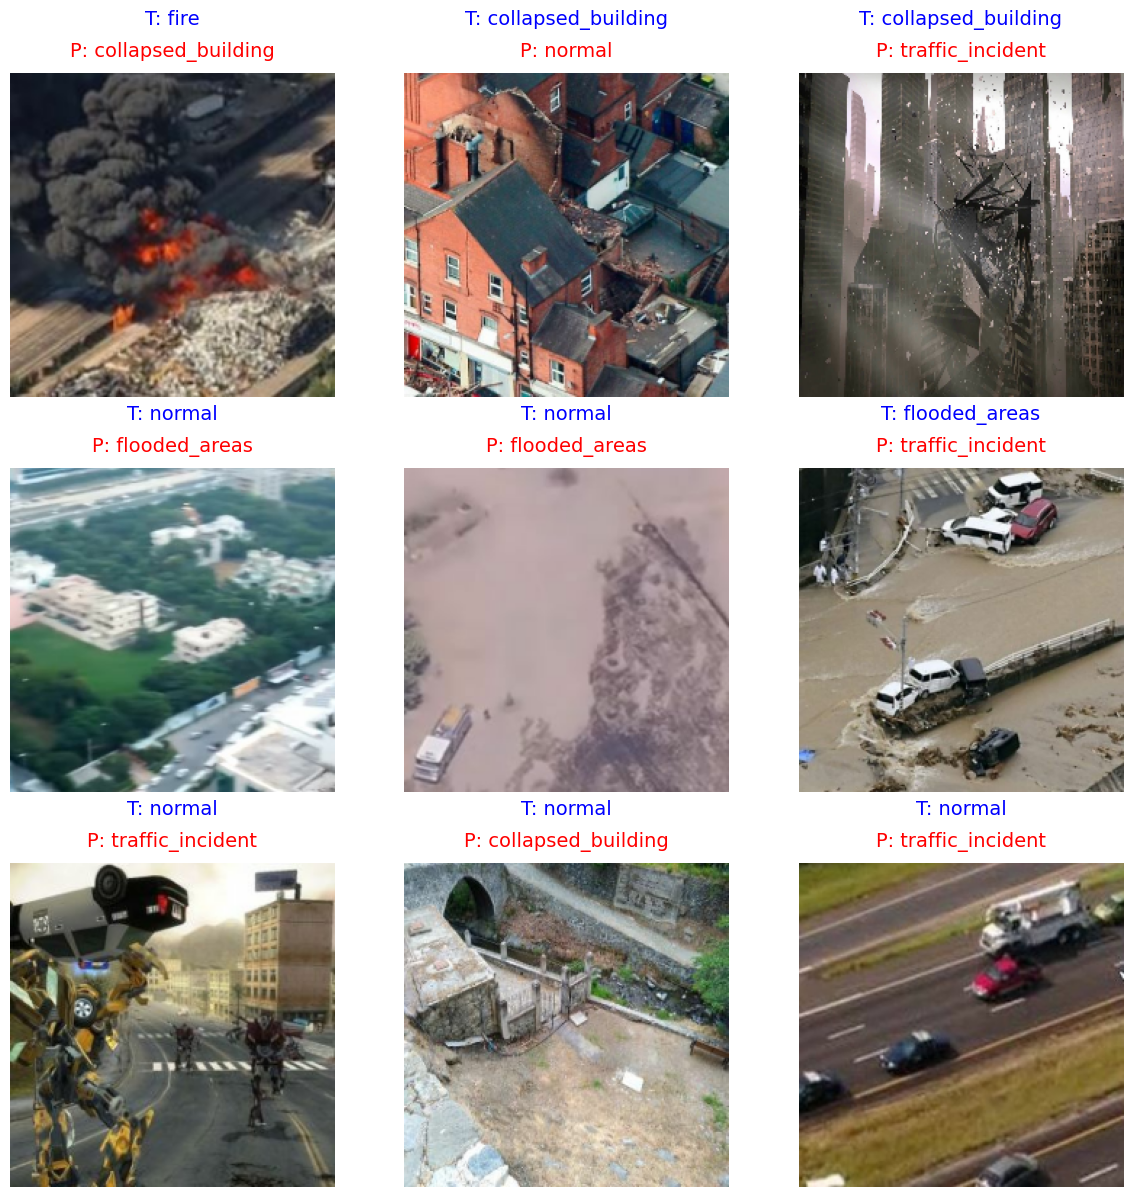

In [ ]:
# show wrong predictions only.
# true in blue, predicted in red or green.
# red = wrong, green = correct.
wrong_indices = np.where(all_preds != all_labels)[0] # get wrong prediction indices. all_preds != all_labels[0] means predicted class is not equal to true class.
print("Number of wrong predictions:", len(wrong_indices))

num_show_wrong = min(9, len(wrong_indices)) # show up to 9 wrong images.
plt.figure(figsize=(12, 12))

for i in range(num_show_wrong):
    idx = wrong_indices[i]
    img = all_images[idx].astype("uint8")

    true_name = class_names[all_labels[idx]]
    pred_name = class_names[all_preds[idx]]
    pred_color = "green" if true_name == pred_name else "red"

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

    plt.text(0.5, 1.15, f"T: {true_name}",
             color="blue", fontsize=14, ha="center",
             transform=plt.gca().transAxes)

    plt.text(0.5, 1.05, f"P: {pred_name}",
             color=pred_color, fontsize=14, ha="center",
             transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()